# Imports 

In [1]:
import numpy as np
import pandas as pd
import sklearn
import time 
import matplotlib
import tensorflow as tf
import random
import seaborn as sns 
import imblearn

print(f'Numpy: {np.__version__}')
print(f'Pandas: {pd.__version__}')
print(f'Sklearn: {sklearn.__version__}')
print(f'Matplotlib: {matplotlib.__version__}')
print(f'TensorFlow:{tf.__version__}')
print(f'Imb-Learn:{imblearn.__version__}')

import warnings
warnings.filterwarnings('ignore')

Numpy: 1.26.4
Pandas: 2.2.2
Sklearn: 1.2.2
Matplotlib: 3.7.5
TensorFlow:2.16.1
Imb-Learn:0.12.3


In [2]:
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score

# DNN 
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy, categorical_crossentropy

# Validation metrics
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve, auc

# Sampling 
from imblearn.over_sampling import SMOTE

# Varibales 

In [3]:
train_path = '/kaggle/input/isic-2024-challenge/train-metadata.csv'
test_path = '/kaggle/input/isic-2024-challenge/test-metadata.csv'

In [4]:
# common columns
#train_cols_set, test_cols_set = set(train_data.columns), set(test_data.columns)
#cols = list(test_cols_set.intersection(train_cols_set))

common_cols = ['sex', 'tbp_lv_deltaLB', 'tbp_lv_location_simple', 'tbp_lv_areaMM2', 'tbp_lv_deltaL', 'tbp_lv_norm_border', 'tbp_lv_A',
 'tbp_lv_B', 'tbp_lv_symm_2axis', 'tbp_lv_L', 'tbp_lv_location', 'tbp_lv_deltaLBnorm', 'tbp_lv_radial_color_std_max',
 'tbp_lv_Lext',  'tbp_lv_Bext', 'tbp_lv_H', 'tbp_lv_perimeterMM', 'tbp_lv_stdL', 'tbp_lv_minorAxisMM', 'tbp_lv_stdLExt',
 'tbp_lv_y', 'tbp_lv_color_std_mean', 'clin_size_long_diam_mm', 'age_approx', 'tbp_lv_eccentricity', 'tbp_lv_deltaA',
 'tbp_tile_type', 'tbp_lv_Hext', 'tbp_lv_C', 'tbp_lv_norm_color', 'tbp_lv_deltaB', 'anatom_site_general', 'tbp_lv_x',
 'tbp_lv_Aext',  'tbp_lv_Cext', 'tbp_lv_symm_2axis_angle', 'tbp_lv_nevi_confidence', 'tbp_lv_z', 'tbp_lv_area_perim_ratio']

In [5]:
# patient_id: Unique patient identifier. (object)
# image_type: Structured field of the ISIC Archive for image type. (o)
# copyright_license: Copyright license. (object)
to_drop = ['isic_id','patient_id','image_type', 'copyright_license', 'attribution']

In [6]:
# categorical columns 
cat_cols_list = ['sex',
                 'tbp_lv_location_simple', 
                 'tbp_lv_location', 
                 'tbp_tile_type', 
                 'anatom_site_general']

# mapping 
sex = {'male':0, 'female':1}

tbp_lv_location_simple =  {'Head & Neck': 0, 
                           'Left Arm': 1, 
                           'Left Leg': 2, 
                           'Right Arm': 3, 
                           'Right Leg': 4, 
                           'Torso Back': 5, 
                           'Torso Front': 6}

tbp_lv_location = {'Head & Neck': 0, 'Left Arm': 1,'Left Arm - Lower': 2, 'Left Arm - Upper': 3,'Left Leg': 4, 
                   'Left Leg - Lower': 5, 'Left Leg - Upper': 6, 'Right Arm': 7, 'Right Arm - Lower': 8, 'Right Arm - Upper': 9, 'Right Leg': 10, 'Right Leg - Lower': 11,
  'Right Leg - Upper': 12, 'Torso Back': 13, 'Torso Back Bottom Third': 14, 'Torso Back Middle Third': 15, 'Torso Back Top Third': 16,
  'Torso Front': 17, 'Torso Front Bottom Half': 18, 'Torso Front Top Half': 19}

tbp_tile_type = {'3D: XP': 0, '3D: white': 1}

anatom_site_general = {'anterior torso': 0, 'head/neck': 1, 'lower extremity': 2, 'posterior torso': 3, 'upper extremity': 4}

# genral dictionary
cat_cols = {'sex': sex, 
           'tbp_lv_location_simple':tbp_lv_location_simple, 
           'tbp_lv_location': tbp_lv_location, 
           'tbp_tile_type':tbp_tile_type,
           'anatom_site_general': anatom_site_general}

The Feature Extraction Section uses Chi-Square, ANOVA F-score, Fisher score and mRMR method to identify the most relevat features. Then Intersection is used to find the common features.  

Chi 2: 27 \
ANOVA:32 \
Fisher:32 \
mRMR:22 \
Common features:15

In [7]:
intersection_cols = ['sex', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_areaMM2',
  'tbp_lv_color_std_mean', 'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_location', 'tbp_lv_location_simple',
  'tbp_lv_minorAxisMM', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max',
  'tbp_lv_stdL']

intersection_cols.append('target')
print(f'16 selected columns +1 target  = {len(intersection_cols)}')

16 selected columns +1 target  = 17


# Classes

In [8]:
class Data:
    
    def __init__(self, path, common_columns, categorical_cols, target_col):
        self.path = path
        self.common_columns = common_columns
        self.categorical_cols = categorical_cols
        self.target_col = target_col
    
    def read_data(self):
        #read data
        self.df = pd.read_csv(self.path,  low_memory=False)
        print(f'Data Shape:{self.df.shape}')

    def data_prep(self):
        
        if self.target_col: 
            self.common_columns.append('target')      
            
        self.df = self.df[self.common_columns] # df with common cols+target 
        print(f'Common Cols:{len(self.common_columns)}.Data Shape: {self.df.shape}')  
        
        # drop missing values
        missing_vals = self.df.isnull().sum().sum()
        if missing_vals > 0:
            self.df = self.df.dropna()
            self.df = self.df.reset_index (drop = True)
            
        print(f'Missing Vals:{missing_vals}.Data Shape: {self.df.shape}')
        
        # remove dublicate 
        print(f'Dublicate Values:{self.df.duplicated().sum()}') # no dublicated values 
        
        #columns mapping
        for key in self.categorical_cols.keys():
            self.df[key] = self.df[key].map(self.categorical_cols[key])
        
        # Scaling columns 
        scaling_lst = list(self.df.select_dtypes(exclude=['int64']).dtypes.index)
        # categorical columns with more than 2 unique values
        scaling_lst.append('tbp_lv_symm_2axis_angle')
        scaling_lst.append('tbp_lv_location_simple')
        scaling_lst.append('tbp_lv_location')
        scaling_lst.append('anatom_site_general')

        scaler = StandardScaler()
        self.df[scaling_lst] = scaler.fit_transform(self.df[scaling_lst])
        
        # shuflle data
        self.df = self.df.sample(frac=1).reset_index(drop=True)
        print(f'Data Shape: {self.df.shape}')
        
        if self.target_col:
            self.common_columns.remove('target')
            
        print(f'Final Shape: {self.df.shape}')
        
    def get_data(self):
        return self.df
        

In [9]:
class DataFrame_Split:
    """
    Aim: create two sub-datasets from the main data file. 
    Each sub-dataset should:
        Contain the same number of attack instances.
        Have an equal of normal samples.
    Return: List of Dfs 
    """
    def __init__(self, df):
        self.df = df  
        
        # normal // mal index 
        norm_indx = self.df[self.df['target'] == 0].index.to_list()
        mal_indx = self.df[self.df['target'] == 1].index.to_list()
        
        # normal // mal df
        self.norm_df = self.df.iloc[norm_indx]
        self.mal_df = self.df.iloc[mal_indx]
        print(f'Malicus df: {self.mal_df.shape} .... Normal df: {self.norm_df.shape}')
        
    def create_random_subsets(self, data, n_splits):
        shuffled_data = data.sample(frac=1).reset_index(drop=True) # Shuffle the dataset
        avg_size = len(shuffled_data) // n_splits # size of each subset

        subsets = []
        for i in range(n_splits):
            start_idx = i * avg_size
            if i == n_splits - 1:  # Make sure the last split gets all remaining data
                subsets.append(shuffled_data[start_idx:])
            else:
                subsets.append(shuffled_data[start_idx:start_idx + avg_size])
        
        return  subsets
        
                
    def main(self):
        norm_sub_dfs = self.create_random_subsets(self.norm_df, n_splits=2)
        
        self.sub_dfs = []
        for i in range(len(norm_sub_dfs)): 
            
            sub_df = pd.concat([norm_sub_dfs[i], self.mal_df], ignore_index=True) # concat dfs 
            sub_df = sub_df.sample(frac=1).reset_index(drop=True) # suffle 
            print(f'Data_{i}: {sub_df.shape}')
            self.sub_dfs.append(sub_df)
                
    def get_sub_df(self):
        return  self.sub_dfs

In [10]:
class Ratio_data():
    
    def __init__(self, df, ratio):
        self.df = df
        self.ratio = ratio # [0, 1]
    
    def data_ratio(self):
        norm_indx = self.df[self.df.target == 0].index.to_list()
        mal_indx = self.df[self.df.target == 1].index.to_list()
        
        # random select ratio of the normal data 
        norm_rand_indx = random.sample(norm_indx, int(len(norm_indx)*self.ratio) )
        
        # select random ratio 
        train_df_norm = self.df.iloc[norm_rand_indx]
        train_df_mal = self.df.iloc[mal_indx]

        self.sub_df = pd.concat([train_df_norm, train_df_mal])
        self.sub_df = self.sub_df.sample(frac=1).reset_index(drop=True) # suffle
        
        
    def split_data(self, test_size = 0.2):
        features, targ = self.sub_df.columns[:-1], self.sub_df.columns[-1] # features / target
        self.X, self.y = self.sub_df[features], self.sub_df[targ]
        # train test split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=test_size, stratify=self.y)
        print(f'Xtrain:{self.X_train.shape} // ytrain:{self.y_train.shape}\nXval:{self.X_test.shape} // yval:{self.y_test.shape}')
        print(f'ytrain {self.y_train.value_counts()}')
        print(f'ytest {self.y_test.value_counts()}')
        
    
    def train_smote(self):
        sm = SMOTE(sampling_strategy = 0.5)
        self.X_res, self.y_res = sm.fit_resample(self.X_train, self.y_train)
        print(f'Smote Data:{self.X_res.shape}\nTarget:{self.y_res.value_counts()}')
        
    def get_X_y(self):
        return self.X, self.y
    
    def get_balance_data(self):
         return self.X_res, self.y_res, self.X_test, self.y_test
        
    def get_imbalance_data(self):
        return self.X_train, self.y_train, self.X_test, self.y_test

In [11]:
def features_dist_plot(df):
    
    plt.figure(figsize=(20, 20)) 
    
    # Loop through the first 15 features and create a subplot for each
    for i, feature in enumerate(df.columns):
        plt.subplot(5, 3, i + 1)  # 5 rows, 3 columns for 15 plots
        sns.histplot(df[feature], kde=True, color='blue')
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Frequency')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()
    
# features_dist_plot(X_train)

In [12]:
class Neural_Network:
    
    def __init__(self, X_train, y_train, X_val, y_val):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        
        # Model
        self.model = Sequential([
            Dense(128, activation= 'relu', input_shape=(16,)),
            tf.keras.layers.BatchNormalization(),
    
            Dense(128, activation= 'relu'),
    
            Dense(64, activation= 'relu'),
            Dense(1, activation= 'sigmoid') # sigmoid/softmax Output layer  
            ]) 
        
        self.history = None  # To store training history
        

    def model_compile(self):
        # SGD optimizer for imbalance 
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
        # tf.keras.optimizers.Adam(clipvalue=1.0) // adam
        
        self.model.compile(
            optimizer = optimizer, 
            loss= tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0, alpha=0.25, 
                                                       from_logits=False),
            metrics=['accuracy']
                            ) # BinaryCrossentropy
    
    def model_summary(self):
        print(self.model.summary())
        
    def model_fit(self):
        # Class Weights
        # # Calculate class weights for the current fold
        # class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        # class_weights = {0: class_weights[0], 1: class_weights[1]}

        class_weights = {0: 0.5099934469200524, 1: 25.516393442622952} # no balance data
        self.history = self.model.fit(
                    self.X_train.values, self.y_train.values, 
                    validation_data=(self.X_val.values, self.y_val.values), 
                    epochs=25, 
                    batch_size=128, 
                    class_weight=class_weights
                    ) # callbacks=[early_stop], 
    def model_history(self):
        # Loss Curves
        plt.figure(figsize=[8,6])
        plt.plot(self.history.history['loss'],'r',linewidth=3.0)
        plt.plot(self.history.history['val_loss'],'b',linewidth=3.0)
        plt.legend(['Training loss', 'Validation Loss'],fontsize=10)
        plt.xlabel('Epochs ',fontsize=10)
        plt.ylabel('Loss',fontsize=10)
        plt.title('Loss Curves',fontsize=10)

        # ccuracy Curves
        plt.figure(figsize=[8,6])
        plt.plot(self.history.history['accuracy'],'r',linewidth=3.0)
        plt.plot(self.history.history['val_accuracy'],'b',linewidth=3.0)
        plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=10)
        plt.xlabel('Epochs ',fontsize=10)
        plt.ylabel('Accuracy',fontsize=10)
        plt.title('Accuracy Curves',fontsize=10)

        plt.legend()
        plt.show()

    def model_roc_curve(self):
        
        y_pred_prob = self.model.predict(self.X_val).ravel()

        # Step 5: Compute ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(self.y_val, y_pred_prob)
        roc_auc = auc(fpr, tpr)

        # Step 6: Plot the ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

            
    def get_model(self):
        return self.model

# Main

In [13]:
# train data 
data_train = Data(path = train_path,
                 common_columns = common_cols, 
                 categorical_cols= cat_cols, 
                 target_col = True)

data_train.read_data() # read data path 
data_train.data_prep() # data preprocessing 

train_df = data_train.get_data()

Data Shape:(401059, 55)
Common Cols:40.Data Shape: (401059, 40)
Missing Vals:20071.Data Shape: (381914, 40)
Dublicate Values:0
Data Shape: (381914, 40)
Final Shape: (381914, 40)


In [14]:
# test data 
data_test = Data(path = test_path,
                 common_columns = common_cols, 
                 categorical_cols= cat_cols, 
                 target_col = False)
data_test.read_data()
data_test.data_prep()

test_df = data_test.get_data()

Data Shape:(3, 44)
Common Cols:39.Data Shape: (3, 39)
Missing Vals:0.Data Shape: (3, 39)
Dublicate Values:0
Data Shape: (3, 39)
Final Shape: (3, 39)


create sub dataset unseen to the model in order u update models weights

In [15]:
train_df = train_df[intersection_cols]
test_df = test_df[intersection_cols[:-1]] # remove target
print(f'Train/Val Data:{train_df.shape}\nTest Data:{test_df.shape}')

Train/Val Data:(381914, 17)
Test Data:(3, 16)


In [16]:
dfs_splits = DataFrame_Split(train_df)

dfs_splits.main()
sub_dfs = dfs_splits.get_sub_df()

train_df_ratio_smote, update_train_df = sub_dfs[0], sub_dfs[1]

Malicus df: (381, 17) .... Normal df: (381533, 17)
Data_0: (191147, 17)
Data_1: (191148, 17)


In [17]:
split = Ratio_data(df = train_df_ratio_smote, 
                         ratio = 0.1)

split.data_ratio()
split.split_data(test_size = 0.2)
split.train_smote()

#X_train, y_train, X_val, y_val = split.get_imbalance_data()
X_train_res, y_train_res, X_val, y_val = split.get_balance_data()

Xtrain:(15565, 16) // ytrain:(15565,)
Xval:(3892, 16) // yval:(3892,)
ytrain target
0    15260
1      305
Name: count, dtype: int64
ytest target
0    3816
1      76
Name: count, dtype: int64
Smote Data:(22890, 16)
Target:target
0    15260
1     7630
Name: count, dtype: int64


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,521 (107.50 KB)

 Trainable params: 27,265 (106.50 KB)

 Non-trainable params: 256 (1.00 KB)

None
Epoch 1/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4978 - loss: 0.3922 - val_accuracy: 0.6811 - val_loss: 0.1973
Epoch 2/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7525 - loss: 0.1403 - val_accuracy: 0.7636 - val_loss: 0.1681
Epoch 3/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8127 - loss: 0.1131 - val_accuracy: 0.7801 - val_loss: 0.1999
Epoch 4/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8462 - loss: 0.0971 - val_accuracy: 0.7757 - val_loss: 0.2014
Epoch 5/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8579 - loss: 0.0922 - val_accuracy: 0.8425 - val_loss: 0.1338
Epoch 6/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8845 - loss: 0.0748 - val_accuracy: 0.8561 - val_loss: 0.1611
Epoch 7/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8941 - loss: 0.0703 - val_accuracy: 0.8571 - val_loss: 0.1469
Epoch 8/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9060 - loss: 0.0618 - val_accurac

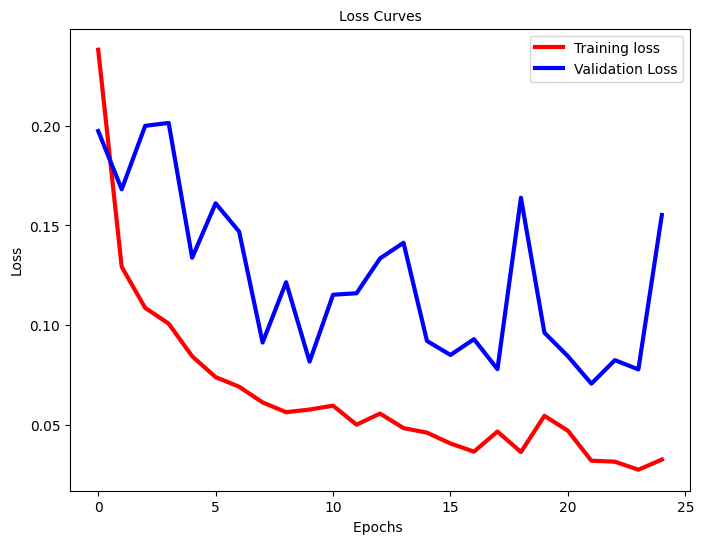

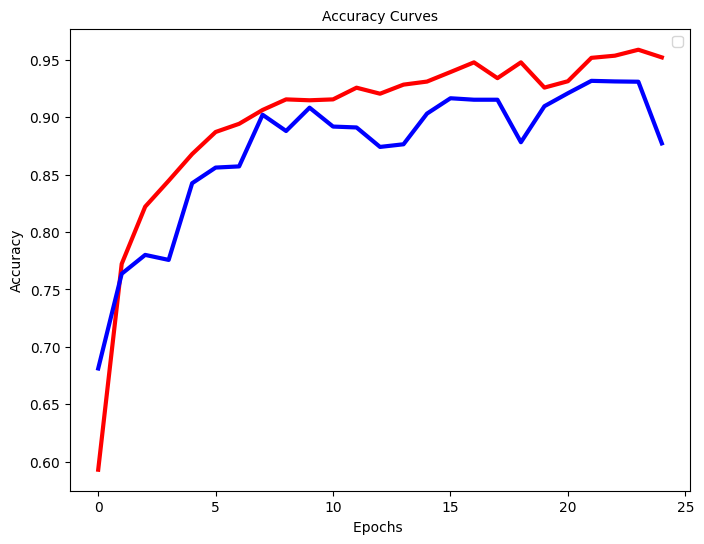

122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


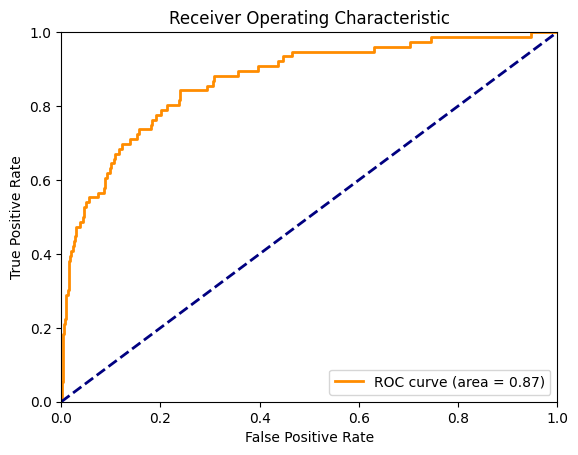

In [18]:
nn = Neural_Network(X_train = X_train_res, 
                    y_train = y_train_res, 
                    X_val = X_val, 
                    y_val = y_val) 
nn.model_compile()
nn.model_summary()
nn.model_fit()
nn.model_history()
nn.model_roc_curve()

In [19]:
trained_model = nn.get_model()

Unseen Data 

In [20]:
unseen_id = [ "ISIC_0015657", "ISIC_0015729", "ISIC_0015740"]

In [21]:
predictions = trained_model.predict(test_df)
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


array([[0.00100946],
       [0.02654432],
       [0.03305418]], dtype=float32)

In [22]:
pred = [p[0].astype(np.float64) for p in predictions ]
pred

[0.0010094557655975223, 0.026544319465756416, 0.0330541767179966]

In [23]:
predictions_df = pd.DataFrame({"isic_id":unseen_id, "target":pred})

In [24]:
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   isic_id  3 non-null      object 
 1   target   3 non-null      float64
dtypes: float64(1), object(1)
memory usage: 176.0+ bytes


In [25]:
predictions_df.to_csv("submission.csv", index = False)